This notebook compares the performance of Gemello with LBM at 2 mins and 15 mins

In [1]:
from create_df import read_df
df, dfc, all_homes, appliance_min, national_average = read_df()

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 24 days


In [2]:
import nilmtk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import warnings

In [3]:
warnings.filterwarnings("ignore")

In [4]:
from nilmtk import *
import os
import nilmtk

In [5]:
st = pd.HDFStore("/Users/nipunbatra/Downloads/wiki-temp.h5")

In [6]:
all_homes_all_appliance=[26.0,
 94.0,
 370.0,
 410.0,
 545.0,
 624.0,
 1283.0,
 1334.0,
 1642.0,
 1953.0,
 2129.0,
 2156.0,
 2242.0,
 2470.0,
 2814.0,
 3367.0,
 3456.0,
 3482.0,
 3723.0,
 3967.0,
 4732.0,
 4767.0,
 5357.0,
 5371.0,
 5746.0,
 5785.0,
 5814.0,
 6072.0,
 6636.0,
 6836.0,
 6910.0,
 7016.0,
 7731.0,
 7769.0,
 7866.0,
 8317.0,
 9052.0,
 9609.0,
 9654.0,
 9922.0,
 9933.0,
 9934.0,
 9982.0]

In [12]:
st_out = pd.HDFStore("../data/output/fhmm_lbm-2-15.h5")

for home in all_homes_all_appliance[:]:
    try:
        pred = pd.read_csv("/Users/nipunbatra/git/monthly-disaggregation/lbm-2min/%d.csv" %home, index_col=0)
        pred.index = pd.to_datetime(pred.index)
        pred = pred['2013']
        pred = pred.resample("1M", how="sum").mul(0.000017).mul(2)
        pred.index = range(1, 13)
        pred = pred[['hvac','dw','dr','fridge','wm','light']]
        
        st_out['%d' %home] = pred
    except Exception, e:
        print e
    
    

26.0
94.0
370.0
410.0
545.0
624.0
1283.0
1334.0
1642.0
1953.0
2129.0
2156.0
2242.0
2470.0
2814.0
3367.0
3456.0
3482.0
3723.0
3967.0
4732.0
4767.0
5357.0
5371.0
5746.0
5785.0
5814.0
6072.0
6636.0
6836.0
6910.0
7016.0
7731.0
7769.0
7866.0
8317.0
9052.0
9609.0
9654.0
9922.0
9933.0
9934.0
9982.0


In [25]:
lbm_accur = {}
stores  = {2:pd.HDFStore("../fhmm_lbm-2-15.h5"), 15:pd.HDFStore("../fhmm_lbm.h5")}

for freq in [2, 15]:
    lbm_accur[freq] = {}
    for appliance in ["hvac","fridge","dw","wm","light","dr"]:
        print appliance, freq

        if appliance =="hvac":
            start, end = 5, 11
        else:
            start, end = 1, 13
        out_ap = {}
        accuracies = {}
        for home in all_homes[appliance][:]:
            out_ap[home] = {}
            pred = stores[freq]['/%d' %home][appliance]
            for month in range(start, end):
                out_ap[home][month] = {}
                gt = df.ix[home]['%s_%d' %(appliance, month)]
                out_ap[home][month]['gt'] = gt
                out_ap[home][month]['pred'] = pred.ix[month]
            a = pd.DataFrame(out_ap[home]).T
            e = (a['gt']-a['pred']).abs().div(a['gt'])*100
            accur = 100-e
            accur[accur<0] = 0
            accuracies[home] = accur
        lbm_accur[freq][appliance] = pd.DataFrame(accuracies).mean().mean()

hvac 2
fridge 2
dw 2
wm 2
light 2
dr 2
hvac 15
fridge 15
dw 15
wm 15
light 15
dr 15


In [34]:
appliance_name_map = {"fridge":"Fridge","hvac":"HVAC","wm":"Washing\nmachine",
                      "dr":"Dryer","dw":"Dish\nwasher","light":"Lights"}

In [81]:
%matplotlib inline
d = pd.DataFrame(lbm_accur).T

In [82]:
d = d.rename(columns=appliance_name_map)

In [83]:
d

,Dryer,Dish washer,Fridge,HVAC,Lights,Washing machine
2,21.063574,24.062129,65.982432,59.983497,41.735498,30.771890
15,5.940615,16.495110,71.822239,55.722782,11.290612,29.972193


In [84]:
d =d.T.ix[['HVAC','Fridge','Washing\nmachine','Lights','Dryer','Dish\nwasher']].T

In [85]:
d

,HVAC,Fridge,Washing machine,Lights,Dryer,Dish washer
2,59.983497,65.982432,30.771890,41.735498,21.063574,24.062129
15,55.722782,71.822239,29.972193,11.290612,5.940615,16.495110


In [86]:
d.index = ['LBM (2 min)', 'LBM (15 min)']

In [87]:
d

,HVAC,Fridge,Washing machine,Lights,Dryer,Dish washer
LBM (2 min),59.983497,65.982432,30.771890,41.735498,21.063574,24.062129
LBM (15 min),55.722782,71.822239,29.972193,11.290612,5.940615,16.495110


In [88]:
from constants import APPROACH

In [89]:
d.loc[APPROACH] = pd.Series({'Dish\nwasher': 27.333401871684234,
 'Dryer': 33.052222078385938,
 'Fridge': 68.541552745826976,
 'HVAC': 76.239355252614146,
 'Lights': 42.757293980395275,
 'Washing\nmachine': 57.272795296939734})

In [90]:
d.ix[0]

HVAC                59.983497
Fridge              65.982432
Washing\nmachine    30.771890
Lights              41.735498
Dryer               21.063574
Dish\nwasher        24.062129
Name: LBM (2 min), dtype: float64

In [91]:
from common_functions import latexify, tableau20blind, format_axes

In [93]:
latexify(columns=1)

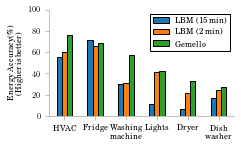

In [96]:
d.ix[['LBM (15 min)', 'LBM (2 min)', APPROACH]].T.plot(kind="bar", 
                                                       colors=tableau20blind[::2]
                                                       , rot=0)
format_axes(plt.gca())
plt.ylim((0,100))
plt.ylabel("Energy Accuracy(\%)\n(Higher is better)");
plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/lbm-time.pdf",bbox_inches="tight")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/lbm-time.png",bbox_inches="tight")